In [2]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58ba0000 @  0x7f494340f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [9]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 44.3MB/s 


# Get the VGG Model

In [0]:
from torchvision import models 
vgg = models.vgg19(pretrained=True).features

## Moving model to GPU

In [30]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

# Freeze the Parameters in VGG, as we dont need backprob 
#### We are going to change only the target image

In [0]:
for param in vgg.parameters():
    param.requires_grad_(False)

# Get the Content and Style image

In [12]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/delaunay.jpg

--2018-11-21 13:00:51--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/delaunay.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102687 (100K) [image/jpeg]
Saving to: ‘delaunay.jpg’

delaunay.jpg        100%[===================>] 100.28K  --.-KB/s    in 0.04s   

2018-11-21 13:00:52 (2.70 MB/s) - ‘delaunay.jpg’ saved [102687/102687]



In [13]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/janelle.png

--2018-11-21 13:01:18--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/janelle.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1085377 (1.0M) [image/png]
Saving to: ‘janelle.png’

janelle.png         100%[===================>]   1.03M  --.-KB/s    in 0.08s   

2018-11-21 13:01:19 (13.5 MB/s) - ‘janelle.png’ saved [1085377/1085377]



In [0]:
from PIL import Image
content_img = Image.open('janelle.png')
style_img = Image.open('delaunay.jpg')

## Content Image

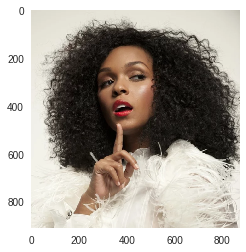

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(content_img)
plt.grid(False)
plt.show()

## Style Image

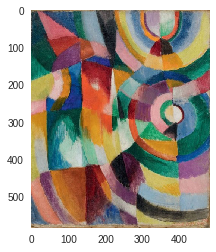

In [23]:
plt.imshow(style_img)
plt.grid(False)
plt.show()

# Image transform

In [0]:
from torchvision import transforms
img_transform = transforms.Compose([transforms.Resize((400, 400)),
                transforms.ToTensor(),
                transforms.Normalize((0.485,0.456, 0.406),(0.229,0.224, 0.225))])

content = img_transform(content_img)[:3,:,:].unsqueeze(0).to(device)
style = img_transform(style_img)[:3,:,:].unsqueeze(0).to(device)  

# Get the feature layers

In [27]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
feature_layers = {'0': 'conv1_1',
          '5': 'conv2_1', 
          '10': 'conv3_1', 
          '19': 'conv4_1',
          '21': 'conv4_2', 
          '28': 'conv5_1'}

### Content features

In [0]:
content_features = {}
img = content # copy of content image
for name, layer in vgg._modules.items():
 img = layer(img)
 if name in feature_layers:
    content_features[feature_layers[name]] = img

### Style features

In [0]:
style_features = {}
img = style # copy of content image
for name, layer in vgg._modules.items():
 img = layer(img)
 if name in feature_layers:
    style_features[feature_layers[name]] = img

In [0]:
# a general function to exrtract the features
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2', 
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

# Gram Matrix

In [0]:
def grammatrix(tensor):
    n, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    grammat = torch.mm(tensor, tensor.t())
    return grammat

In [0]:
style_gram_matrix = {layer: grammatrix(style_features[layer]) for layer in style_features}

# Target Image

In [0]:
target = content.clone().requires_grad_(True).to(device)

# weights initialization

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # this is alpha in the final loss
style_weight = 1e6  # this is beta in the final loss

# Training loop

In [0]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

Total loss:  141632.90625


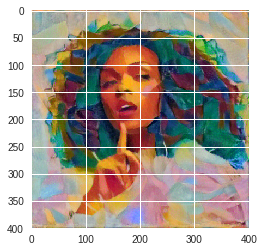

Total loss:  86419.3359375


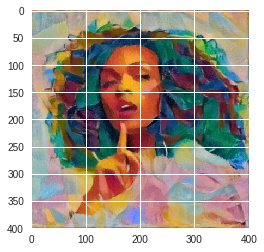

Total loss:  69088.8828125


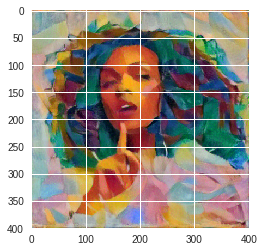

Total loss:  59777.90625


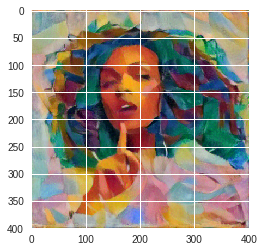

Total loss:  54193.67578125


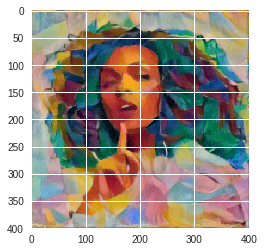

In [55]:
from torch import optim
import numpy as np

show_img = 400

optimizer = optim.Adam([target], lr=0.003)
steps = 2000  

for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = grammatrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_gram_matrix[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    

    if  ii % show_img == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

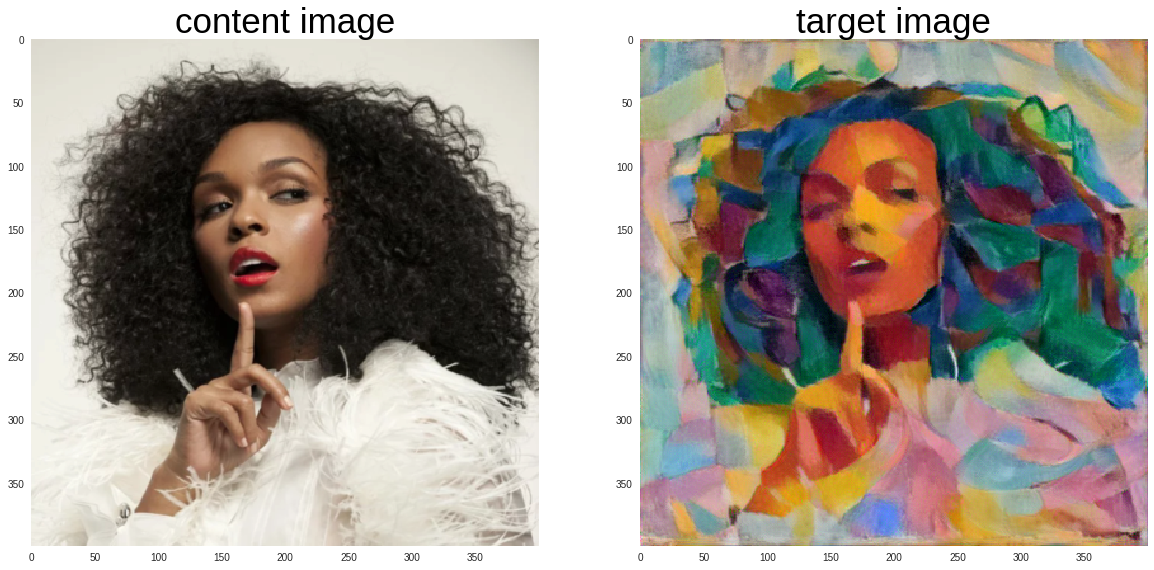

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.grid(False)
ax2.grid(False)
ax1.set_title('content image', fontsize="35", color="black")
ax2.set_title('target image', fontsize="35", color="black")
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))
plt.show()